# Bayesian Optimization

[Bayesian optimization](https://en.wikipedia.org/wiki/Bayesian_optimization)  is a powerful strategy to find extrema of objective functions which are costly to evaluate, not easy to have access to their derivatives, and possibly containing noise. It is a machenism lying behind [automated machine learning](https://en.wikipedia.org/wiki/Automated_machine_learning) toolboxes such as [auto-sklearn](https://automl.github.io/auto-sklearn/stable/), [auto-weka](http://www.cs.ubc.ca/labs/beta/Projects/autoweka/), [scikit-optimize](https://scikit-optimize.github.io/) to select best hyperparameters for machine learning models. As mentioned in the review reference [2], Bayesian optimization is used for a wide range of other applications such as interactive user-interfaces, robotics, environmental monitoring, information extraction, combinatorial optimisation, sensor networks, adaptive Monte Carlo, experimental design, reinforcement learning. The innovation [AlphaGo Zero](https://en.wikipedia.org/wiki/AlphaGo_Zero) also uses Bayesian optimization to tune its tree search's hyperparameters.

Assume that we have an optimization problem
$$ x^* = \text{arg}\min \ f(x), $$
where $f$ is an unknown objective function. To solve it, we will construct a sequence of points $\{x_n\}$ which converges to $x^*$. The Bayesian optimization strategy works as follows:
1. Place a prior on the possibilities of the objective function. The model will be updated each time we evaluate more data to form a posterior distribution over the objective function.
2. Derive from the posterior an "acquisition" function $\alpha(x)$ which is easy to evaluate and get derivatives (hence optimizing $\alpha(x)$ is easy). 
3. Repeat until convergence:
    + Use the acquisition function to derive the next query point according to
    $$ x_{n+1} = \text{arg}\min \ \alpha(x). $$
    + Evaluate $f(x_{n+1})$ and update the posterior.

The acquisition function should utilize the uncertainty of the posterior to encourage exploring more information about $f$. After evaluating a new data point, the model will be updated and the derived acquisition function will exploit it to give the next candidate for the minimum point of $f$. After a number of steps, it is likely that $\{x_n\}$ will converge to $x^*$.

In this tutorial, we will see how to use the [Gaussian Process module]((http://docs.pyro.ai/en/dev/contrib.gp.html) in Pyro to do Bayesian optimization.

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import torch
import torch.autograd as autograd
import torch.optim as optim
from torch.distributions import constraints, transform_to

import pyro
import pyro.contrib.gp as gp
pyro.set_rng_seed(0)

import os
smoke_test = ('CI' in os.environ)
pyro.enable_validation(False) # MVN precision conversion issue - see: https://github.com/uber/pyro/issues/953

## Define a problem

For the purpose of demonstration, the objective function we are going to solve is the [Forrester et al. (2008) function](https://www.sfu.ca/~ssurjano/forretal08.html):
$$f(x) = (6x-2)^2 \sin(12x-4), \quad x\in [0, 1].$$

This function has both local minimum and global minimum. The global minimum is $0.75725$.

In [2]:
def f(x):
    return (6 * x - 2)**2 * torch.sin(12 * x - 4)

Let's take a plot for $f$.

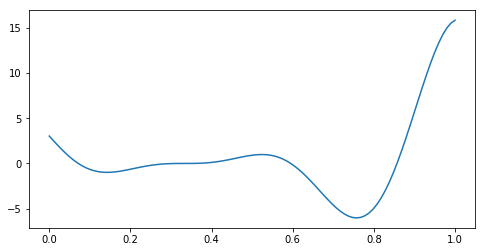

In [3]:
x = torch.linspace(0, 1)
plt.figure(figsize=(8, 4))
plt.plot(x.numpy(), f(x).numpy())
plt.show()

## Set a Gaussian Process prior

[Gaussian process](https://en.wikipedia.org/wiki/Gaussian_process) is a popular choice for a distribution over functions due to its power and flexibility (characteristics of a non-parametric model). The core of a Gaussian Process is its covariance function $k$ which governs the similarity between input points. Here we will use a Gaussian Process regression as a prior over the objective function $f$. Given inputs $X$ and their noisy observations $y$, the model takes the form
$$f\sim\mathrm{MultivariateNormal}(0,k(X,X)),$$
$$y\sim f+\epsilon,$$
where $\epsilon$ is noise and $k(X,X)$ is a covariance matrix whose entries are outputs $k(x,z)$ of $k$ over input pairs $(x,z)$.

The [Matern52](https://en.wikipedia.org/wiki/Mat%C3%A9rn_covariance_function) kernel will be chose (as suggested in reference [1]) because the popular [RBF](https://en.wikipedia.org/wiki/Radial_basis_function_kernel) kernel is so smooth that makes it an unrealistic assumption for the objective function.

In [4]:
# init the model with two input points -0.1 and 1.1
X = torch.tensor([-0.1, 1.1])
y = f(X)
gpmodel = gp.models.GPRegression(X, y, gp.kernels.Matern52(input_dim=1),
                                 noise=torch.tensor(0.01))

The following helper function `update_posterior` will take care of updating our `gpmodel` when a new $x$ is found.

In [5]:
def update_posterior(x_new):
    y = f(x_new)
    X = torch.cat([gpmodel.X, x_new])
    y = torch.cat([gpmodel.y, y])
    gpmodel.set_data(X, y)
    gpmodel.optimize()

## Define an acquisition function

There are many choices for the acquisition function (see references [1] and [2] for a list of popular ones and discussions on them). Here we will use a "simple to implement and interpret" one: Lower Confidence Bound, which is two standard deviations below posterior mean. Formally,
$$
\alpha(x) = \mu(x) - \kappa \sigma(x),\quad \kappa = 2,
$$
where $\mu(x)$ and $\sigma(x)$ are mean and variance of the posterior, and the coefficient $\kappa$ plays a trade-off between exploitation-exploration. A high $\kappa$ means that we play more weight on exploration (because we seek minimum candidates in a higher-uncertainty area). Otherwise, we do exploitation: seek minimum candidates around the posterior mean $\mu(x)$.

In [6]:
def lower_confidence_bound(x, kappa=2):
    mu, variance = gpmodel(x, full_cov=False, noiseless=False)
    sigma = variance.sqrt()
    return mu - kappa * sigma

The final component is a way to find a minimum point for acquisition function. There are several ways for us to choose: gradient-based and non-gradient-based. Here, we will follow the gradient-based approach. One of the drawback of gradient descent methods is it is easy for the minimizer to get stuck at a local minimum. In this tutorial, we will use a simple way to solve that problem. First, draw $3$ samples from our Gaussian Process posteriors and find a candidate for each sample. Then (after collecting $3$ candidates), we select the minimum point among them. A more detailed discussion regarding to this problem in Bayesian Optimization is presented in the reference [2].

In [7]:
def find_a_candidate(x_init, lower_bound=0, upper_bound=1):
    # transform x to an unconstrained domain to set an minimizer for it
    constraint = constraints.interval(lower_bound, upper_bound)
    unconstrained_x_init = transform_to(constraint).inv(x_init)
    unconstrained_x = torch.tensor(unconstrained_x_init, requires_grad=True)
    minimizer = optim.LBFGS([unconstrained_x])

    def closure():
        minimizer.zero_grad()
        x = transform_to(constraint)(unconstrained_x)
        y = lower_confidence_bound(x)
        autograd.backward(unconstrained_x, autograd.grad(y, unconstrained_x))
        return y
    
    minimizer.step(closure)
    # after a candidate found in unconstrained domain, convert it back to original domain
    x = transform_to(constraint)(unconstrained_x)
    return x.detach()

In [8]:
def next_x(lower_bound=0, upper_bound=1, num_candidates=3):
    candidates = []
    values = []

    # last data point will be an init point for first minimum candidate,
    # other minimum candidates will get uniform random initialization
    x_init = gpmodel.X[-1:]
    for i in range(num_candidates):
        x = find_a_candidate(x_init, lower_bound, upper_bound)
        y = lower_confidence_bound(x)
        candidates.append(x)
        values.append(y)
        x_init = x.new_empty(1).uniform_(lower_bound, upper_bound)

    argmin = torch.min(torch.cat(values), dim=0)[1].item()
    return candidates[argmin]

## Find $\{ x_n \}$

To illustrate how Bayesian Optimization works, we make a convenient plotting function.

In [9]:
def plot(gs, xmin, xlabel=None, with_title=True):
    xlabel = "xmin" if xlabel is None else "x{}".format(xlabel)
    Xnew = torch.linspace(-0.1, 1.1)
    ax1 = plt.subplot(gs[0])
    ax1.plot(gpmodel.X.numpy(), gpmodel.y.numpy(), "kx")  # plot all observed data
    with torch.no_grad():
        loc, var = gpmodel(Xnew, full_cov=False, noiseless=False)
        sd = var.sqrt()
        ax1.plot(Xnew.numpy(), loc.numpy(), "r", lw=2)  # plot prediction mean
        ax1.fill_between(Xnew.numpy(), loc.numpy() - 2*sd.numpy(), loc.numpy() + 2*sd.numpy(),
                         color="C0", alpha=0.3)  # plot uncertainty intervals
    ax1.set_xlim(-0.1, 1.1)
    ax1.set_title("Find {}".format(xlabel))
    if with_title:
        ax1.set_ylabel("Gaussian Process Regression")

    ax2 = plt.subplot(gs[1])
    with torch.no_grad():
        ax2.plot(Xnew.numpy(), lower_confidence_bound(Xnew).numpy())  # plot acquisition
        ax2.plot(xmin.numpy(), lower_confidence_bound(xmin).numpy(), "^", markersize=10,
                 label="{} = {:.5f}".format(xlabel, xmin.item()))  # plot minimum point
    ax2.set_xlim(-0.1, 1.1)
    if with_title:
        ax2.set_ylabel("Lower Confidence Bound")
    ax2.legend(loc=1)

First, we generate a random point `x0` in the interval $[0, 1]$. Then use `update_posterior` and `next_x` functions repeatly to do Bayesian optimization for $f$. The following plot illustrates how Gaussian Process posteriors and their derived acquisition functions change when we observe more data for the next $10$ steps.

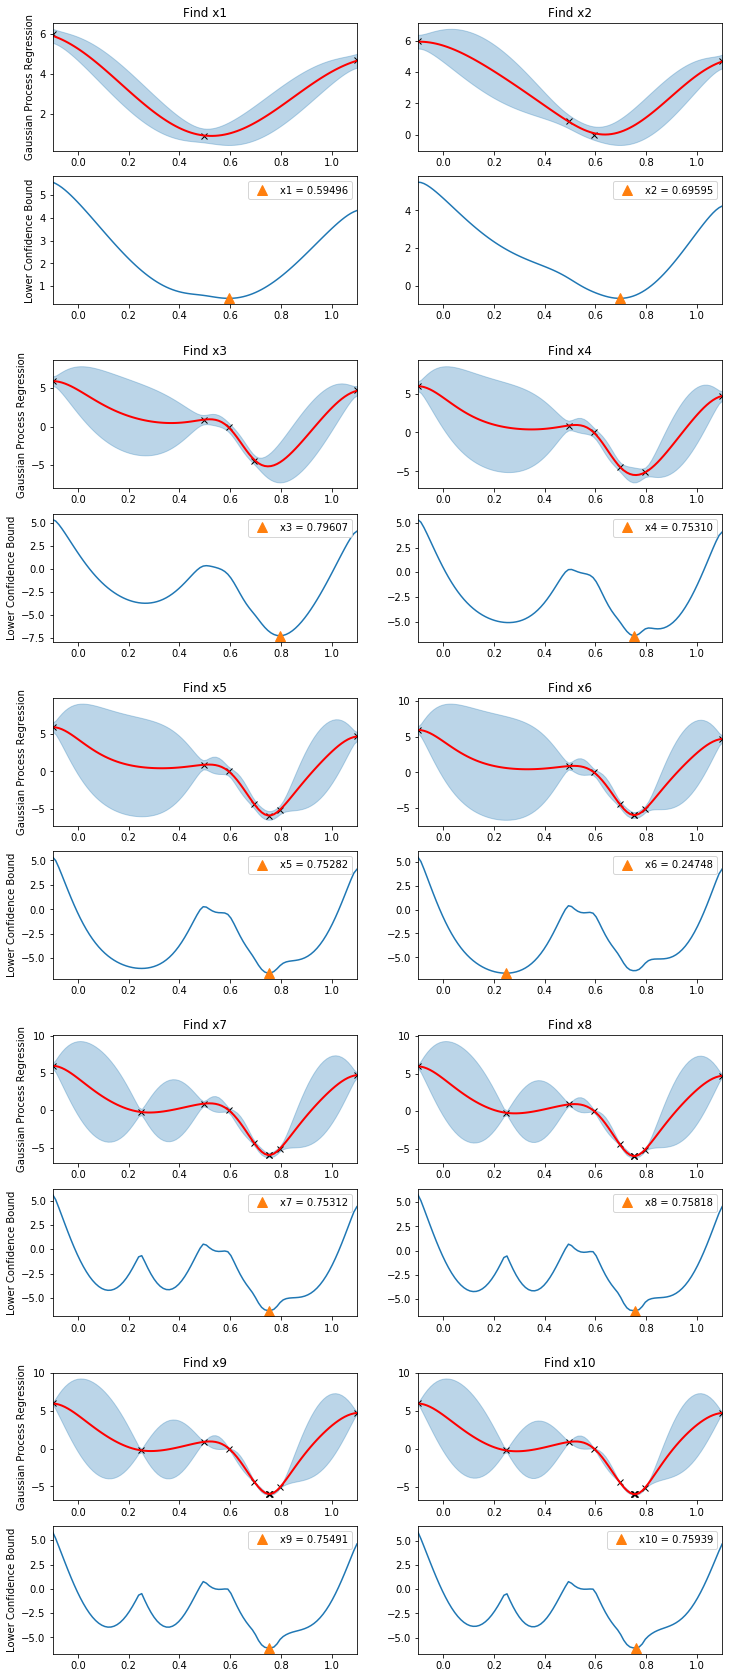

In [10]:
plt.figure(figsize=(12, 30))
outer_gs = gridspec.GridSpec(5, 2)
x0 = X.new_empty(1).uniform_(0, 1)
xmin = x0
for i in range(10 if not smoke_test else 1):
    update_posterior(xmin)
    xmin = next_x()
    gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer_gs[i])
    plot(gs, xmin, xlabel=i+1, with_title=(i % 2 == 0))

The plot for $x7$ illustrates the "exploration" property of acquisition function. Because we made an assumption that our observations contain noise, it is improbable to require an exact result. However, we can see that the sequence has converged to near the global minimum $0.75725$. That's it! Through this tutorial, we hope that we have conveyed some basic ideas of Bayesian optimization. For more reference, the youtube video [3] is an excellent course to learn the basic theory. And the paper [2] gives a review of current progresses on this subject, together with many discussions about technical details.

## References

[1] `Practical bayesian optimization of machine learning algorithms`,<br />&nbsp;&nbsp;&nbsp;&nbsp;
Jasper Snoek, Hugo Larochelle, and Ryan P. Adams

[2] `Taking the human out of the loop: A review of bayesian optimization`,<br />&nbsp;&nbsp;&nbsp;&nbsp;
Bobak Shahriari, Kevin Swersky, Ziyu Wang, Ryan P. Adams, and Nando De Freitas

[3] [Machine learning - Bayesian optimization and multi-armed bandits](https://www.youtube.com/watch?v=vz3D36VXefI)